# Distances

In this notebook, we will explore the time series distance functions available in the
 aeon toolkit. We focus on the technical usage of distances. For more formal
 description, please see [1].

The goal of a distance computation is to measure the dis-similarity between the time
series 'x' and 'y'. A distance function should take x and y as parameters and return
a float that is the computed distance between x and y. The value returned should be 0
.0 when the time series are the exact same, and a value greater than 0.0 that is a
measure of distance between them, when they are different.

Distance functions can be used in all time series machine learning tasks. In
[classification](examples/classification/distance_based.py) and [regression](examples/regression/distance_based.py) they are
employed in, for example nearest neighbour classifiers/regressors. In [clustering]
(examples/clustering/distance_based.py) they are central to $k$-means and $k$-medoids
 clustering.

The goal of a distance computation is to measure the similarity between the time
series. A distance function should take two time series as parameters and
return the distance as a float. The value returned should be 0.0 when the time series
 are the exact same, and a value greater than 0.0 that is a measure of
distance between them, when they are different.

Structure
1. Simple use case
2. Motivation for elastic distances
2. Bounding box parameters
3. Pairwise distances
4. Alignment paths
4. Multivariate distances
4. References

## Simple Use Case

distance functions take two 1D or 2D numpy array input and calculate a distance. If a
 series has more than one channel (i.e. multivariate time series), it should be stored
  as shape `(d,n)`. Univariate time series of length $n$ can be modelled as either
  shape `(n,)` or `(1,n)`. The simplest distance is Euclidean distance. This measures the sum of squared
distances between points. The most popular time series specific distance is dynamic
time warping (DTW). These and other distance functions are imported form aeon.distances.

In [36]:
import numpy as np

from aeon.distances import dtw_distance, euclidean_distance

x = np.array([1, 2, 3, 4, 5, 6])  # Univariate as 1D
y = np.array([2, 3, 4, 5, 6, 7])
d1 = euclidean_distance(x, y)
d2 = dtw_distance(x, y)
print(f" ED 1 = {d1} DTW 1 = {d2}")
x = np.array([[1, 2, 3, 4, 5, 6]])  # Univariate as 2D
y = np.array([[2, 3, 4, 5, 6, 7]])
d1 = euclidean_distance(x, y)
d2 = dtw_distance(x, y)
print(f" ED 2 = {d1} DTW 2 = {d2}")
x = np.array([[1, 2, 3, 4, 5, 6], [3, 4, 3, 4, 3, 4]])  # Multivariate, 2 channels
y = np.array([[2, 3, 4, 5, 6, 7], [7, 6, 5, 4, 3, 2]])
d1 = euclidean_distance(x, y)
d2 = dtw_distance(x, y)
print(f" ED 3 = {d1} DTW 3 = {d2}")

 ED 1 = 2.449489742783178 DTW 1 = 2.0
 ED 2 = 2.449489742783178 DTW 2 = 2.0
 ED 3 = 5.830951894845301 DTW 3 = 34.0


## Basic Motivation for Elastic Distances

As an example we will use data from the gunpoint data. This is a two class problem.
If a distance function is to be useful, we hope it will measure lower distances between
instances of the same class than those of different classes. We extract three cases
as an example.

(200, 1, 150)
 class values 2, 1, 2


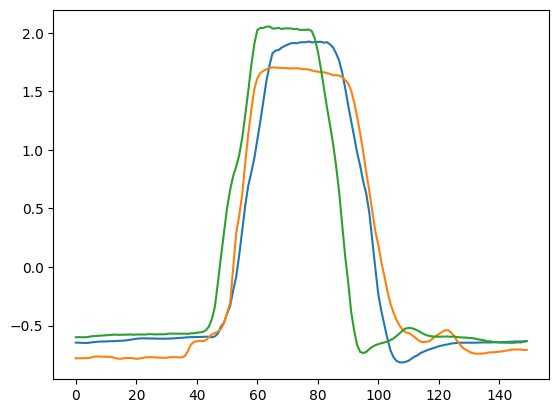

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_gunpoint

X, y = load_gunpoint()
print(X.shape)
first = X[1][0]
second = X[2][0]
third = X[4][0]
plt.plot(first)
plt.plot(second)
plt.plot(third)
print(f" class values {y[1]}, {y[2]}, {y[4]}")

 The problem with Euclidean distance is it takes no account
of the order, and so a small offset can lead to large distances. For this problem,
the discriminatory information is in the small areas before and after the peak
(around points 30-50 and 100-130). In the example
above, the first and third example are in the same class, but the peaks are
offset. This means there is a larger distance between these cases and the second
example.

In [32]:
from aeon.distances import euclidean_distance

d1 = euclidean_distance(first, second)
d2 = euclidean_distance(first, third)
d3 = euclidean_distance(second, third)
print(d1, ",", d2, ",", d3)

2.490586847171778 , 6.307592298519925 , 6.618889405616554


Elastic distances such dynamic time warping realign series to compensate for offset.
If we use `dtw_distance` instead of `eucldean_distance`

In [35]:
from aeon.distances import dtw_distance

d1 = dtw_distance(first, second)
d2 = dtw_distance(first, third)
d3 = dtw_distance(second, third)
print(d1, ",", d2, ",", d3)

1.733128174164524 , 0.5299968542651227 , 3.666430398991013


we see now the first example is closer to the one in its own class than the second
example.

At the time of writing, aeon contains the following distance functions
-'euclidean': standard Euclidean distance
-'dtw': dynamic time warping
-'ddtw': derivative DTW [2]
-'wdtw': weighted DTW [3]
-'wddtw': weighted derivative DTW [3]
-'lcss': Longest common subsequence
-'edr': edit distance with real sequences [4]
-'erp' edit real penalty [4]
-'msm': move split merge [5]
-'twe': time warp edit [6]
for more details on each distance see the documentation and [1].


### Custom parameters for distances

Each distance function has a different set of parameters. This table from [1] below
summarises the properties
<img src="./dist_parameters.png" width="400"">
For specific parameters for each distance please refer to the documentation.

In this notebook we focus on one parameter all distances can use, but is usually
associated with one distance function. The bounding box for DTW.

DTW is a $O(n^2)$ algorithm and as such a point of focus has been trying to optimise the
algorithm. A proposal to improve performance is to restrict the potential alignment
path by putting a 'bound' on values to consider when looking for an alignment. While
there have been many bounding algorithms proposed the most popular is known as
Sakoe-Chiba's bounding window. First this is a bounding matrix that considers all
indexes in x and y:

In [3]:
from aeon.distances import create_bounding_matrix

first_ts_size = 10
second_ts_size = 5

create_bounding_matrix(first_ts_size, second_ts_size)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

Above shows a matrix that maps each index in 'x' to each index in 'y'. Each value
that is considered in the computation is set to True (in this instance we want a full
bounding matrix so all values are set to True). As such if we were to run Dtw with this
without bounding matrix all values will be consider all of these indexes.

However, it sometimes (depending on the dataset) is not necessary (and sometimes
detrimental to the result) to consider all indexes. We can you a bounding technique
like Sakoe-Chibas to limit the potential warping paths. This is done by setting a window
size that will restrict the indexes that are considered. Below shows creating a bounding
matrix again but only considering 20% of the indexes in x and y:

In [5]:
create_bounding_matrix(first_ts_size, second_ts_size, window=0.2)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

This bounding matrix produces a diagnol shape over the matrix. This restricts the
warping and therefore greatly increase the speed at which the distance is computed as
much fewer potential warping paths are considered.

## Pairwise distances

It is common to want a matrix of pairwise distances for a collation of time series.
For example, medoid based clustering and certain sklearn estimators can work directly
 with distance functions. It is easy to get a pairwise distance function in aeon.
 This can either be for a single collection or

In [42]:
from aeon.datasets import load_arrow_head
from aeon.distances import msm_pairwise_distance

X_train, _ = load_arrow_head(split="train")
X_test, _ = load_arrow_head(split="test")
X1 = X_train[:5]
X2 = X_test[:6]
train_dist_matrix = msm_pairwise_distance(X1)
test_dist_matrix = msm_pairwise_distance(X1, X2)
print(
    f"Single X dist pairwise is square and symmetrical shape "
    f"= {train_dist_matrix.shape}\n{train_dist_matrix}"
)
print(
    f"Two X dist pairwise is all dists from X1 (row) to X2 (column), so shape "
    f"shape = {test_dist_matrix.shape}\n{test_dist_matrix}"
)

Single X dist pairwise is square and symmetrical shape = (5, 5)
[[ 0.         62.2553732  45.91702356 49.72138985 50.07185968]
 [62.2553732   0.         31.06762179 93.31791099 25.73406576]
 [45.91702356 31.06762179  0.         82.05754675 32.71868983]
 [49.72138985 93.31791099 82.05754675  0.         79.50156797]
 [50.07185968 25.73406576 32.71868983 79.50156797  0.        ]]
Two X dist pairwise is all dists from X1 (row) to X2 (column), so shape shape = (5, 6)
[[ 21.01701605  22.16699488  86.45534374  75.69573009  48.79410225
   33.27495124]
 [ 63.76668286  59.61188967  93.89293437 109.6967054   92.68370785
   47.78485799]
 [ 44.01308016  39.55587095  99.06160623  94.98620404  85.33606252
   34.36027177]
 [ 53.21801989  60.05103978  72.37115291  64.11310795  24.86221373
   66.65632674]
 [ 48.70558166  48.82369739  88.5358956  101.44412148  80.20208926
   37.59557677]]


## Alignment paths

When elastic distances are calculated, they effectively align the two indexes.


## Multivariate distances

# References

[1] Chris holder
[2] Keogh, Eamonn & Pazzani, Michael. Derivative Dynamic Time Warping.
    First SIAM International Conference on Data Mining, 2002.
[3] Young-Seon Jeong, Myong K. Jeong, Olufemi A. Omitaomu, Weighted dynamic time
    warping for time series classification, Pattern Recognition, Volume 44, Issue 9,
    2011.
[4] Chen L, Ozsu MT, Oria V: Robust and fast similarity search for moving
object trajectories. In: Proceedings of the ACM SIGMOD International Conference
on Management of Data, 2005.
[5] Stefan A., Athitsos V., Das G.: The Move-Split-Merge metric for time
series. IEEE Transactions on Knowledge and Data Engineering 25(6), 2013.
[6] Marteau, P.; F. Time Warp Edit Distance with Stiffness Adjustment
    for Time Series Matching. IEEE Transactions on Pattern Analysis and Machine
    Intelligence. 31 (2), 2009/